In [1]:
from sqlalchemy import create_engine, func, inspect
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.schema import Table,MetaData
from sqlalchemy import Column, Integer, Float, ForeignKey
from geoalchemy2 import Geometry
from geoalchemy2.functions import GenericFunction
from geoalchemy2.elements import WKTElement, WKBElement
from sqlalchemy.orm import sessionmaker, relationship, backref, aliased
from math import sqrt, atan2, pi, log10, log, sin, cos, radians, atan
from Scientific.Geometry import Vector
import numpy as np

from WormDBStuff.WormDBStuff import WormDBStuffFactory


basename = 'ravatAppBasinPSG1250'

WormPointStd, WormLevelPointsStd, WormLevelStd, tablenames = WormDBStuffFactory(basename)

class WormPoint(WormPointStd):
    normal_angle_to_sigma_1 = Column(Float)
    angle_std_dev = Column(Float)
    risk_category = Column(Float)
    
class WormLevelPoints(WormLevelPointsStd):
    pass

class WormLevel(WormLevelStd):
    pass
    

layer_name = tablenames['layer_name']
points_name = tablenames['points_name']
levels_name = tablenames['levels_name']
levels_points_name = tablenames['levels_points_name']

Base = declarative_base()

class ST_Collect(GenericFunction):
    name = 'ST_Collect'
    type = Geometry


In [2]:
db = 'postgresql://frank@localhost/frank'
engine = create_engine('%s'%db, echo=False)
Session = sessionmaker(bind=engine)
session = Session()
connect = engine.connect()
if not engine.dialect.has_table(connect, points_name):
    raise AttributeError('The Points table is missing.')
if not engine.dialect.has_table(connect, levels_name):
    raise AttributeError('The Levels table is missing.')
if not engine.dialect.has_table(connect, levels_points_name):
    raise AttributeError('The Levels_Points table is missing.')
    
meta = MetaData()

class Wsm2008(Base):
    __table__ = Table('wsm2008', meta, autoload=True, autoload_with=engine)
    

In [3]:
def gc_dist(lat1,lon1,lat2,lon2):
    # cribbed from <http://code.activestate.com/recipes/
    # 576779-calculating-distance-between-two-geographic-points/>
    R = 6371.0
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    
    dlon = (lon2 - lon1)
    dlat = (lat2 - lat1)
    a = (sin(dlat/2.))**2 + cos(lat1) * cos(lat2) * (sin(dlon/2.))**2
    c = 2. * atan2(sqrt(a), sqrt(1.-a))
    return R * c


In [4]:
def directional_stats_from_wsm(wsms,dists,idxs):
    """ This is the weighted directional stats as used in the WSM 2008 paper.
        As of this writing, I have not been able to find a correct citation
        for this weighted version of Mardia (1972)'s algorithm.
        I even have my doubts about its accuracy since the very heart of 
        Mardia (1972)'s approach involves unit vectors lying on the circle, 
        and this approach implicitly sums vectors of less than unit length.  
        I am therefore simply reproducing the WSM 2008 algorithm in the hopes
        that it is viable. They incorrectly cite Mardia (1972) for the origin
        of this algorithm.
        BAD FORM WSM2008 Authors and Tectonophysics reviewers/editors!
        At the very least, get your citations correct!
    """
    # This is Z in Heidbach et al.
    weight_sum = 0.
    C_bar_prime = 0.
    S_bar_prime = 0.
    for w,d in zip(np.array(wsms)[idxs],dists[idxs]):
        az = w.AZI
        az_rad = az*(2.*pi)/360.
        qual = w.QUALITY
        if qual == 'A':
            w_q = 1./15.
        elif qual == 'B':
            w_q = 1./20.
        elif qual == 'C':
            w_q = 1./25.
        w_D = min(1./d, 1./20.)
        weight = w_q*w_D
        # These 2 * az arguments are from the paper, but smell funny.
        C_bar_prime += weight * cos(2.*az_rad)
        S_bar_prime += weight * sin(2.*az_rad)
        weight_sum += weight
        
    C_bar_prime /= weight_sum
    S_bar_prime /= weight_sum
    R_bar_prime = sqrt((C_bar_prime**2) + (S_bar_prime**2))
    SHat_H_radians = (atan2(S_bar_prime,C_bar_prime)/2.) 
    SHat_H_deg = SHat_H_radians * 360./(2.*pi)
    if SHat_H_deg < 0.:
        SHat_H_deg += 180.
    #SHat_H_deg = SHat_H_deg % 180.
    S_0_prime = 1. - R_bar_prime
    S_0_tilde = 1. - (1. - S_0_prime)**0.25
    s_0_deg = (sqrt(-2.*log(1.-S_0_tilde))/2.)*180./pi
    s_0_prime_deg = sqrt(-2.*log(1.-S_0_prime))*180./pi
    return R_bar_prime, S_0_tilde, SHat_H_deg, s_0_deg, s_0_prime_deg

def directional_stats_from_worms(vector_list):
    # This is the true directional stats from Mardia (1972)
    sum_vect = Vector(x=0.,y=0.,z=0.)
    N = float(len(vector_list))
    for v in vector_list:
        sum_vect = sum_vect + v.normal()
    R_bar = sum_vect.length()/N
    S_0 = 1. - R_bar
    s_0_deg = sqrt(-2.*log(1.-S_0))*360./(2.*pi)
    return R_bar,S_0,s_0_deg



In [5]:
def kmToDegrees(km):
    return 360. * km / (6371.*2.*pi)

In [6]:
point_query = \
    session.query(WormPoint,WormLevelPoints)\
    .filter(WormPoint.worm_point_id == WormLevelPoints.point_id)

In [7]:
wsm08_query = session.query(Wsm2008).filter(Wsm2008.QUALITY.in_('ABC'))

In [ ]:
az_diffs = []
wsm_azs = []
wsm_az_sds = []
wsm_az_prime_sds = []
seg_rats = []
North = Vector(x=1., y=0., z=0.)
km_1000_degs = kmToDegrees(1000.)

lvl_ids = [1,2,3]
wlp = aliased(WormLevelPoints)
wp = aliased(WormPoint)
# Critical angles for Byerlee's Law
lo_crit = 65.2
hi_crit = 114.8
# Delta angle for risk classification
da = 5.
for p in point_query.filter(WormLevelPoints.worm_level_id.in_(lvl_ids))\
                           .order_by(WormLevelPoints.worm_seg_id,
                                     WormLevelPoints.seg_sequence_num):
        central = p.WormPoint
        # First off find all World Stress Map control points within 1000 kms
        wsmq = wsm08_query.filter(func.ST_DWithin(Wsm2008.position,
                                                  func.ST_SetSRID(central.wgs84_pt,4326),
                                                  km_1000_degs))
        wsm_nearby = wsmq.all()
        if len(wsm_nearby) < 5:
            continue
        
        # call into the bloody database to dig the lons and lats out of central
        # N.B. we do NOT need to have a valid SRID here, which is a good thing
        # since geoalchemy2 seems to have trouble getting SRIDs from the db.
        central_lon,central_lat = session.query(func.ST_X(central.wgs84_pt),
                                                func.ST_Y(central.wgs84_pt)).one()
        # compute the distances between central and the wsm points
        dists = np.array([gc_dist(w.LAT,w.LON,central_lat,central_lon) for w in wsm_nearby],np.float32)
        #sorted_dist_idxs = np.argsort(dists)
        # Match the algorithm in the Heidbach et al. WSM paper
        
        for dist_lim in np.arange(1000.,99.,-100.):  
            limited_range_idxs = np.argwhere(dists<=dist_lim).transpose()[0]
            # Estimate the directional stats
            R_Bar, S_0, SHat_H_deg, s_0_deg_wsm, s_0_prime_deg = directional_stats_from_wsm(wsm_nearby, dists, limited_range_idxs)
            if s_0_deg_wsm < 25.:
                break
        else:
            # We've reached 100 kms, and not found a std dev of less than 25 degrees;
            # Move on the the next worm point.
            continue
            
        if len(limited_range_idxs) < 5:
            # Censoring this worm point because we don't have enough control points in the range.
            continue

        wsm_azs += [SHat_H_deg]
        wsm_az_sds += [s_0_deg_wsm]
        wsm_az_prime_sds += [s_0_prime_deg]
        
        back_seg = p.WormLevelPoints
        wsi = back_seg.worm_seg_id
        ssn = back_seg.seg_sequence_num
        fwd_seg = session.query(wlp).filter(wlp.worm_level_id == back_seg.worm_level_id,
                                            wlp.worm_seg_id == wsi,
                                            wlp.seg_sequence_num == ssn+1).all()
        if fwd_seg == []:
            continue
        fwd_seg = fwd_seg[0]
        bss_pt_id = back_seg.start_point_id
        fse_pt_id = fwd_seg.point_id
        bs_start = session.query(wp).filter(wp.worm_point_id == bss_pt_id).one()
        fs_end = session.query(wp).filter(wp.worm_point_id == fse_pt_id).one()
        back_az = back_seg.azimuth
        fwd_az = fwd_seg.azimuth
        secant = Vector( x=(fs_end.x - bs_start.x), y=(fs_end.y - bs_start.y), z=0. )
        
        s_norm = secant.normal()
        s_norm_cos = s_norm.y()
        s_norm_sin = s_norm.x()
        secant_az = atan2(s_norm_sin,s_norm_cos)*360./(2.*pi)
        secant_normal_az = secant_az + 90.
        #secant_az = secant.angle(North)*360./(2.*pi)
        a_diff = secant_normal_az - SHat_H_deg
        if a_diff < 0.:
            a_diff += 180.
        if a_diff > 180.:
            a_diff += -180.
        
        az_diffs += [a_diff]
        
        central.normal_angle_to_sigma_1 = a_diff
        
        if   ( ( a_diff <= (lo_crit - 3.*da) ) ):
            central.risk_category = 2
        elif ( ( a_diff >  (lo_crit - 3.*da) ) and
               ( a_diff <= (lo_crit - 2.*da) ) ):
            central.risk_category = 3
        elif ( ( a_diff >  (lo_crit - 2.*da) ) and
               ( a_diff <= (lo_crit - 1.*da) ) ):
            central.risk_category = 4
        elif ( ( a_diff >  (lo_crit - 1.*da) ) and
               ( a_diff <= (lo_crit + 1.*da) ) ):
            central.risk_category = 5
        elif ( ( a_diff >  (lo_crit + 1.*da) ) and
               ( a_diff <= (lo_crit + 2.*da) ) ):
            central.risk_category = 4
        elif ( ( a_diff >  (lo_crit + 2.*da) ) and
               ( a_diff <= (lo_crit + 3.*da) ) ):
            central.risk_category = 3
        elif ( ( a_diff >  (lo_crit + 3.*da) ) and
               ( a_diff <= (hi_crit - 3.*da) ) ):
            central.risk_category = 2
        elif ( ( a_diff >  (hi_crit - 3.*da) ) and
               ( a_diff <= (hi_crit - 2.*da) ) ):
            central.risk_category = 3
        elif ( ( a_diff >  (hi_crit - 2.*da) ) and
               ( a_diff <= (hi_crit - 1.*da) ) ):
            central.risk_category = 4
        elif ( ( a_diff >  (hi_crit - 1.*da) ) and
               ( a_diff <= (hi_crit + 1.*da) ) ):
            central.risk_category = 5
        elif ( ( a_diff >  (hi_crit + 1.*da) ) and
               ( a_diff <= (hi_crit + 2.*da) ) ):
            central.risk_category = 4
        elif ( ( a_diff >  (hi_crit + 2.*da) ) and
               ( a_diff <= (hi_crit + 3.*da) ) ):
            central.risk_category = 3
        elif ( ( a_diff >  (hi_crit + 3.*da) ) ):
            central.risk_category = 2
        
        
        bs = Vector(x=(central.x - bs_start.x), y=(central.y - bs_start.y), z=0.)
        bs_az = bs.angle(North)*360./(2.*pi)

        
        fs = Vector(x=(fs_end.x - central.x), y=(fs_end.y - central.y), z=0.)
        fs_az = fs.angle(North)*360./(2.*pi)

        R_Bar,S_0,s_0_deg = directional_stats_from_worms([bs,fs])
        
        propagated_angular_error = sqrt(s_0_deg**2 + s_0_deg_wsm**2)
        
        central.angle_std_dev = propagated_angular_error

        #print secant_az, bs_az, fs_az, S_0, R_bar, s_0_deg
        # OK. "Chi by eye" suggests that we have the right order of magnitude here.
        # Here, the secant_az is what we will use for the orientation of the 
        # worm segment, and s_0_deg is the standard deviation of the error
        # in that angle (in degrees). 
        # FIXME: look up in section 3.7.1 of Mardia what distribution the
        # standard deviation transformation is valid for.

session.commit()

In [9]:
%debug

> <ipython-input-8-4a74b6a2b50a>(57)<module>()
     56 
---> 57         back_seg = p.WormLevelPoints
     58         wsi = back_seg.worm_seg_id

ipdb> p p
(<__main__.WormPoint object at 0x111a22790>, <WormDBStuff.WormDBStuff.WormLevelPointsStd object at 0x111a22bd0>)
ipdb> q


In [39]:
somept = central.wgs84_pt

In [18]:
print session.scalar(central.pt.ST_SetSRID(4326).ST_SRID())

AttributeError: Neither 'Function' object nor 'Comparator' object has an attribute 'ST_SRID'

In [48]:
session.rollback()

In [12]:
print bs_start.wgs84_pt

01b90b00008eabf6b7f42152c06343bcb083ba4440000000000088b3c01630815b77b305c0


In [49]:
foo = session.scalar(func.ST_SetSRID(p.WormPoint.wgs84_pt,4326))

In [56]:
session.scalar(func.ST_SRID(func.ST_AsEWKB(foo)))

4326

ST_SetSRID(ST_GeomFromWKB(:ST_GeomFromWKB_1, :ST_GeomFromWKB_2), :ST_SetSRID_1)


In [4]:
worm_segs = session.query(WormLevelPoints).filter(WormLevelPoints.worm_level_id == 2).order_by(WormLevelPoints.worm_seg_id)

In [5]:
print worm_segs

SELECT "AppBasinBGA2500_levels_points".worm_level_id AS "AppBasinBGA2500_levels_points_worm_level_id", "AppBasinBGA2500_levels_points".point_id AS "AppBasinBGA2500_levels_points_point_id", "AppBasinBGA2500_levels_points".worm_seg_id AS "AppBasinBGA2500_levels_points_worm_seg_id", "AppBasinBGA2500_levels_points".seg_sequence_num AS "AppBasinBGA2500_levels_points_seg_sequence_num", ST_AsBinary("AppBasinBGA2500_levels_points".line_segmt) AS "AppBasinBGA2500_levels_points_line_segmt", "AppBasinBGA2500_levels_points".line_grad AS "AppBasinBGA2500_levels_points_line_grad" 
FROM "AppBasinBGA2500_levels_points" 
WHERE "AppBasinBGA2500_levels_points".worm_level_id = :worm_level_id_1 ORDER BY "AppBasinBGA2500_levels_points".worm_seg_id


In [6]:
for s in worm_segs:
    print s.worm_seg_id,s.seg_sequence_num

0 0
0 1
0 2
0 3
0 4
0 5
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15
4 0
4 1
4 2
4 3
4 4
4 5
5 0
5 1
6 0
6 1
7 0
7 1
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
8 10
8 11
8 12
9 0
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
9 10
9 11
9 12
9 13
9 14
9 15
9 16
9 17
9 18
9 19
9 20
9 21
9 22
9 23
9 24
9 25
9 26
9 27
9 28
9 29
9 30
9 31
9 32
9 33
9 34
9 35
9 36
9 37
9 38
9 39
9 40
10 0
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
10 10
10 11
10 12
10 13
10 14
10 15
10 16
10 17
10 18
10 19
10 20
10 21
10 22
10 23
10 24
10 25
10 26
10 27
10 28
10 29
10 30
10 31
10 32
10 33
10 34
10 35
10 36
10 37
10 38
10 39
10 40
10 41
10 42
10 43
10 44
10 45
10 46
10 47
10 48
10 49
10 50
10 51
10 52
10 53
10 54
10 55
10 56
10 57
10 58
10 59
10 60
10 61
10 62
10 63
10 64
10 65
10 66
10 67
10 68
10 69
10 70
10 71
10 72
10 73
10 74
10 75
10 76
10 77
11 0
11 1
11 2
11 3
11 4
11 5
11 6
11 7
11 8
11 9
11 10
12 0
12 1
12 2
12 

In [48]:
km_3000_degs = 360.*3000./(6371.*2.*pi*2.*pi)
wsm_pts = wsm08_query.filter(func.ST_DWithin(Wsm2008.position,func.ST_SetSRID(somept,4326),km_3000_degs)).all()
print np.max([w.AZI for w in wsm_pts]), len(wsm_pts)

165 69


In [4]:
session.query(Wsm2008.position.ST_SRID()).filter(Wsm2008.QUALITY.in_('ABC')).distinct().all()

[(4326)]

In [4]:
env_stmt = session.query(func.ST_Collect(WormLevelPoints.wgs84_line_segmt).ST_Envelope())

In [ ]:
session.query(func.ST_AsText(env_stmt)).all()

In [6]:
print foo

[<geoalchemy2.functions.ST_AsText at 0x103197250; ST_AsText>]


In [10]:
azs = []
for p in point_query.filter(WormLevelPoints.worm_level_id == 3):
                           # WormLevelPoints.azimuth != 0.): 
                           # WormLevelPoints.azimuth != 90.,
                           # WormLevelPoints.azimuth != -90.):
    azs += [p.WormLevelPoints.azimuth + 180.]

In [13]:
%matplotlib inline
from matplotlib import pyplot as plt

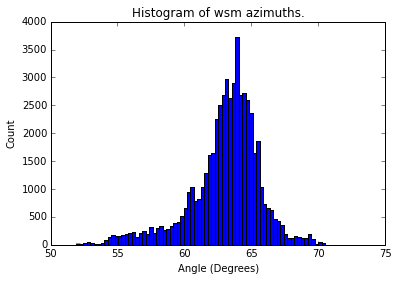

In [20]:
foo = plt.hist(wsm_azs,bins=72,cumulative=False)
plt.xlabel('Angle (Degrees)')
plt.ylabel('Count')
plt.title('Histogram of wsm azimuths.')

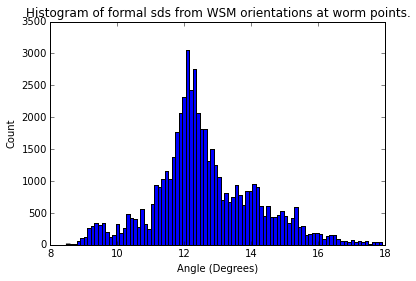

In [21]:
bar = plt.hist(wsm_az_sds,bins=90,cumulative=False)
plt.xlabel('Angle (Degrees)')
plt.ylabel('Count')
plt.title('Histogram of formal sds from WSM orientations at worm points.')

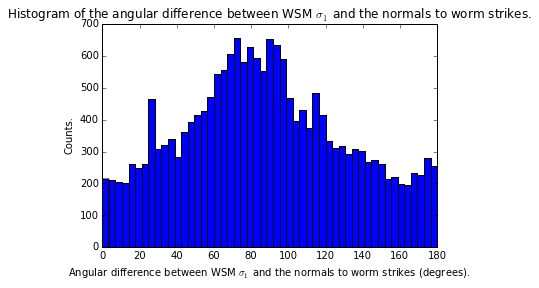

In [22]:
baz = plt.hist(az_diffs,bins=51,cumulative=False)
plt.title("Histogram of the angular difference between WSM $\sigma_1$ and the normals to worm strikes.")
plt.xlabel("Angular difference between WSM $\sigma_1$ and the normals to worm strikes (degrees).")
plt.ylabel("Counts.")

The basic idea here for deriving the critical angle from $\sigma_1$ is from Mohr's circle and Byerlee's (1978) Law. The following image, from Rick Allmendinger's Mohr Plotter software, shows the geometry in Mohr space.
<img src="MohrPlotterCircles.png">

For the depth ranges of interest, Byerlee's Law claims a coefficient of friction of 0.85 on pre-existing surfaces. Byerlee's Law is the straight line failure envelope above. Define the friction angle $\omega$ as equal to the angle from the Byerlee failure envelope to the $\sigma(n)$ axis. By the definition of coefficient of friction, $\mu = \sigma(s) / \sigma(n) = 0.85$ for Byerlee's Law. From simple trig, $\omega = tan^{-1}(\mu) \approx 40.36^\circ$.

From the geometry of the Mohr's circle, the angle $2 \theta$ from $\sigma_1$ to the normal of a plane ideally oriented for failure by Byerlee's Law (shown in the plot above as the red point and line) is given by $(90^\circ - \omega) + 2\theta_{crit} = 180^\circ$. This reduces to $\theta_{crit} = 45^\circ + \omega/2 \approx 65.2^\circ$.

There are two orientations of interest here: the positive one (counter-clockwise from $\sigma(n)$) and the negative one (clockwise from $\sigma(n)$). Those orientations show up in the angular histogram plotted above as $180^\circ - \theta_{crit} \approx 114.8^\circ$ and $\theta_{crit} \approx 65.2^\circ$ respectively.

WARNING! The following discussion assumes that the $\sigma_1$ -- $\sigma_3$ plane is horizontal; implying a strike-slip fault motion. There are other variations of this basic argument for when $\sigma_2$ is not the vertical principal stress direction.  In other words, this argument applies precisely to only one of the three cases for E.M. Anderson's fault dynamics model!

For the purpose of assembling the combined risk analyses, Jery Stedinger requested a continuous variable with risk categories defined by specified ranges thereof. Given that we have NO information about the magnitude of stresses available (only the interpolated WSM $\sigma_1$ directions), unfortunately we CAN NOT meaningfully estimate the distance from a failure envelope in Mohr space as mechanics demands. Hence, I hereby declare that the angle from $\theta_{crit}$ and it's propagated error will be that continuous variable for this aspect of the project. For this piece of code, we will add additional attributes to the WormPoint database records (i.e. "migrate" the database schema; BLOODY DATABASES! Grrr!) containing the (minimum) difference angle from the (two) $\theta_{crit}$ value(s) and an estimate of its variance.

Worm segment strike-normals (a.k.a. "dip directions" to Commonwealth trained geologists) that lie within different angular ranges from $\theta_{crit}$ will be categorized as "High, Medium High, Medium, and Medium Low" risks for activation. "Low" risk will be reserved for areas away from worms.


(There is another failure law, Griffith-Coulomb -- the curved failure envelope plotted above and valid for intact rock -- that conceivably could come into play here. For this first-cut rough draft, we will ignore that.)


Reference:

Byerlee, J. (1978). Friction of rocks. Pure and Applied Geophysics, 116 (4-5), 615-626.
URL http://dx.doi.org/10.1007/bf00876528

In [26]:
atan(0.85)*360./(2.*pi)

40.36453657309736

In [28]:
45.+(atan(0.85)*360./(2.*pi))/2.

65.18226828654868

In [29]:
180. - 65.18226828654868

114.81773171345132